## Delta Method Analysis Tutorial
This notebook shows how the DeltaMethodAnalysis class is performing the Delta Method for a simple ratio metric. In this case the cluster column is going to be at user level for the current example.

We start by exemplifying why the method is useful and when it has to be used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date
from scipy.stats import norm
from statsmodels.formula.api import ols

from cluster_experiments import BinaryPerturbator
from cluster_experiments import ClusteredSplitter
from cluster_experiments import DeltaMethodAnalysis
from cluster_experiments import PowerAnalysis
from tests.utils import generate_ratio_metric_data


In [2]:
def naive_ttest(data):
    data= data.groupby(['user', 'treatment']).agg({'target':'sum', 'scale':'sum'}).reset_index()
    data['metric']  = data['target']/data['scale']
    stats = data.groupby('treatment').agg(
        mean = ('metric', 'mean'),
        var = ('metric', 'var'),
        num_samples = ('scale', 'sum')
        )

    mean_dif = stats.loc['A', 'mean'] - stats.loc['B', 'mean']
    var_dif = stats.loc['A', 'var']/stats.loc['A', 'num_samples'] + stats.loc['B', 'var']/stats.loc['B', 'num_samples']
    z_score = mean_dif/np.sqrt(var_dif)
    pval = 2 * (1 - norm.cdf(abs(z_score)))
    return pval

def generate_data(N, num_users=2000, user_sample_mean=0.3, user_standard_error=0.5, treatment_effect=0.1):
    exp_dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(14, 32)]

    user_target_means = np.random.normal(user_sample_mean, user_standard_error, num_users)

    #data generation
    data = generate_ratio_metric_data(exp_dates, N, user_target_means, num_users, treatment_effect)
    return data

def compare_vanilla_cuped(N, num_users=2000, user_sample_mean=0.3, user_standard_error=0.5, treatment_effect=0.1):
    #data generation
    data = generate_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect)

    analysis_delta = DeltaMethodAnalysis(
        cluster_cols=["user"]
    )
    delta_pval = analysis_delta.get_pvalue(data)


    #naive t-test considering the same randomization unit at user level
    naive_ttest_pval = naive_ttest(data)

    #OLS without clustered errors
    #map treatment to binary number

    data['treatment'] = data['treatment'].map({'A': 0, 'B': 1})

    ols_result = ols('Y ~ treatment ', pd.DataFrame({'Y': data.target, 'treatment': data.treatment})).fit()
    naive_ols_pval = ols_result.pvalues['treatment']
    #OLS with clustered errors
    ols_result_clustered = ols('Y ~ treatment ', pd.DataFrame({'Y': data.target, 'treatment': data.treatment})).fit(cov_type='cluster', cov_kwds={'groups': data['user']})
    naive_ols_clustered_pval = ols_result_clustered.pvalues['treatment']


    return naive_ttest_pval, naive_ols_pval, naive_ols_clustered_pval, delta_pval

### A-A test for validation

In [3]:
# Let's generate some fake switchback data (the clusters here would be city and date
N = 200_000

naive_ttest_p_values = []
naive_ols_clustered_p_values = []
naive_ols_p_values = []
delta_p_values = []

for _ in range(200):
    naive_ttest_pval, naive_ols_pval, naive_ols_clustered_pval, delta_pval = compare_vanilla_cuped(N, num_users = 5_000, treatment_effect= 0)
    naive_ttest_p_values.append(naive_ttest_pval)
    naive_ols_p_values.append(naive_ols_pval)
    naive_ols_clustered_p_values.append(naive_ols_clustered_pval)
    delta_p_values.append(delta_pval)

print(f"Naive average p-value t-test: {np.mean(naive_ttest_p_values)}")
print(f"Naive average OLS p-value: {np.mean(naive_ols_p_values)}")
print(f"Average OLS w/ clustered errors p-value: {np.mean(naive_ols_clustered_p_values)}")
print(f"Delta Method average p-value: {np.mean(delta_p_values)}")

Naive average p-value t-test: 0.08820678021915838
Naive average OLS p-value: 0.1380091920705585
Average OLS w/ clustered errors p-value: 0.5071697690571216
Delta Method average p-value: 0.5072002733744696


In [4]:
positives_prop_ttest = np.mean([pval< 0.05 for pval in naive_ttest_p_values])
positives_prop_ols = np.mean([pval< 0.05 for pval in naive_ols_p_values])
positives_user_clustered_ols = np.mean([pval< 0.05 for pval in naive_ols_clustered_p_values])
positives_delta = np.mean([pval< 0.05 for pval in delta_p_values])

print(f"Naive false positives rate t-test: {positives_prop_ttest}")
print(f"Naive false positives rate OLS p-value: {positives_prop_ols}")
print(f"False positives rate OLS w/ clustered errors: {positives_user_clustered_ols}")
print(f"False positives rate Delta Method: {positives_delta}")

Naive false positives rate t-test: 0.78
Naive false positives rate OLS p-value: 0.66
False positives rate OLS w/ clustered errors: 0.065
False positives rate Delta Method: 0.065


#### Check p-val distributions

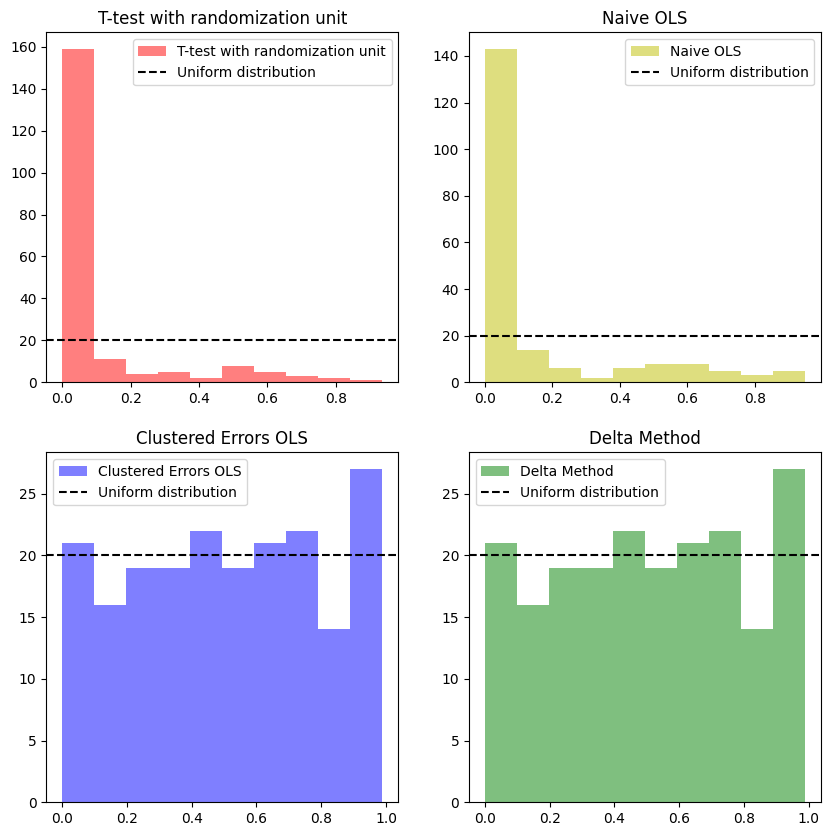

In [5]:
# Do a subfigure with four plots 2x2 of the p-values add also uniform distribution line
num_bins = 10
uniform_line = len(naive_ttest_p_values)/num_bins

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(naive_ttest_p_values, bins=num_bins, alpha=0.5, label='T-test with randomization unit', color='r')
axs[0, 0].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[0, 0].set_title('T-test with randomization unit')
axs[0, 0].legend()
axs[0, 1].hist(naive_ols_p_values, bins=num_bins, alpha=0.5, label='Naive OLS', color='y')
axs[0, 1].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[0, 1].set_title('Naive OLS')
axs[0, 1].legend()
axs[1, 0].hist(naive_ols_clustered_p_values, bins=num_bins, alpha=0.5, label='Clustered Errors OLS', color='b')
axs[1, 0].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[1, 0].set_title('Clustered Errors OLS')
axs[1, 0].legend()
axs[1, 1].hist(delta_p_values, bins=num_bins, alpha=0.5, label='Delta Method', color='g')
axs[1, 1].axhline(y=uniform_line, color='black', linestyle='--', label='Uniform distribution')
axs[1, 1].set_title('Delta Method')
axs[1, 1].legend()
plt.show()

In the A/A test we should expect a distribution resembling a uniform distribution. As we can see unless we are using the Delta Method or Clustered Errors this is not the case. 
The advantage of the Delta Method lies in its performance as compared to OLS.

It is known that Naive t-test will have a smaller estimation of the variance, increasing the false positive rate

### Example of usage

In [6]:
N = 200_000
num_users=5_000
user_sample_mean=0.3
user_standard_error=0.5
treatment_effect=0.1

# data generation
data = generate_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect)

# Delta Method
analysis_delta = DeltaMethodAnalysis(
    cluster_cols=["user"]
)
delta_pval = analysis_delta.get_pvalue(data)


print(f"Vanilla Delta Method p-value: {delta_pval}")

Vanilla Delta Method p-value: 0.0


### Example of usage in Power Analysis

In [7]:
# Splitter and perturbator
sw = ClusteredSplitter(
    cluster_cols=["user"],
)

perturbator = BinaryPerturbator(
    average_effect=0.02,
)

# Vainilla Delta Method
analysis = DeltaMethodAnalysis(
    cluster_cols=["user"],

)
pw_vanilla = PowerAnalysis(
    perturbator=perturbator,
    splitter=sw,
    analysis=analysis,
    n_simulations=50,
)

data = generate_data(N, num_users, user_sample_mean, user_standard_error, treatment_effect = 0)
data = data.drop(columns=['treatment'])
power = pw_vanilla.power_analysis(data)
print(f"Delta Method: {power = }")



Delta Method: power = np.float64(0.56)
